In [ ]:
# Importing libaries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from scipy.stats import chi2_contingency
import re
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (confusion_matrix,  
                           accuracy_score) 
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_auc_score
!pip install imblearn
from imblearn.over_sampling import SMOTE
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import plot_confusion_matrix

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 33.9 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 24.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
# Read in cleaned dataset
full_df = pd.read_csv('/work/combined_df.csv')

## Logistic regression

We initially tried using logistic regression as our response variable is binary but realized some assumptions were not met (extreme class imbalance & nonlinearity of independent variables and log odds), thereby leading us to try out a different, more suitable model.

Classification Report:
              precision    recall  f1-score   support

           0       0.85      1.00      0.92       943
           1       0.00      0.00      0.00       165

    accuracy                           0.85      1108
   macro avg       0.43      0.50      0.46      1108
weighted avg       0.72      0.85      0.78      1108

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

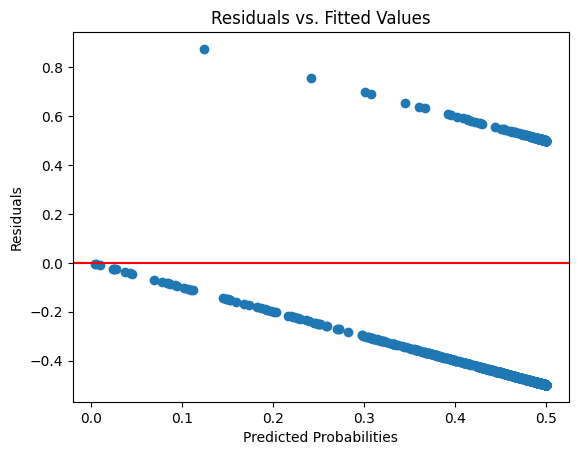

In [ ]:
# Select relevant features and target variable
X = full_df[['sqft']]
y = full_df['has_wood_frame']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

lr = LogisticRegression(class_weight='balanced').fit(X_train, y_train)

# Predicting on the test data
pred_test = lr.predict(X_test)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, pred_test))

# Predict probabilities
y_pred_prob = lr.predict_proba(X_test)[:, 1]

# Calculate residuals
residuals = y_test - y_pred_prob

# Plot residuals vs. fitted values
plt.scatter(y_pred_prob, residuals)
plt.xlabel('Predicted Probabilities')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values')
plt.axhline(y=0, color='r', linestyle='-')  # Add horizontal line at y=0
plt.show()

In [ ]:
# confusion matrix 
cm = confusion_matrix(y_test, pred_test)  
print ("Confusion Matrix : \n", cm)  
  
# accuracy score of the model 
print('Test accuracy = ', accuracy_score(y_test, pred_test))

Confusion Matrix : 
 [[943   0]
 [165   0]]
Test accuracy =  0.8510830324909747


Binned residual plot: diagnostic tool for checking the linearity assumption in logistic regression:

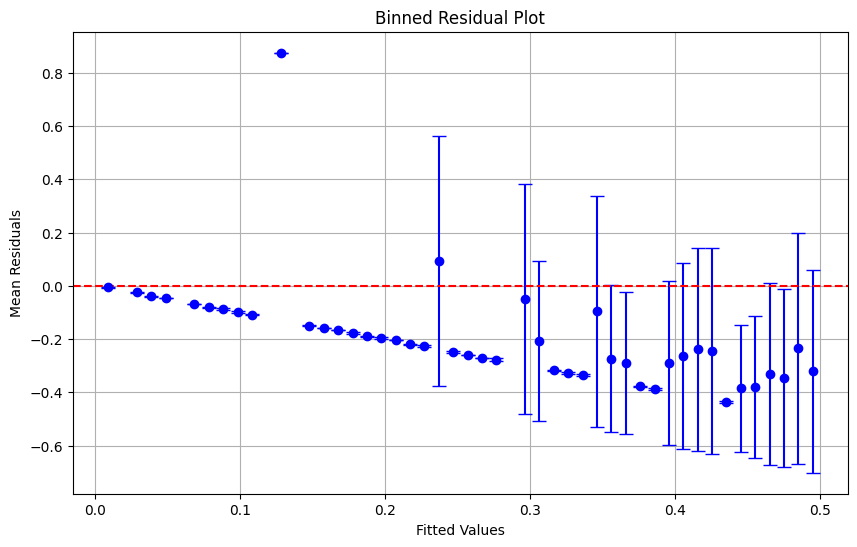

In [ ]:
def binned_residual_plot(y_true, y_pred, num_bins=10):
    # Calculate residuals
    residuals = y_true - y_pred
    
    # Bin residuals based on fitted values
    bins = np.linspace(np.min(y_pred), np.max(y_pred), num_bins + 1)
    binned_res = [residuals[(y_pred >= bins[i]) & (y_pred < bins[i+1])] for i in range(len(bins)-1)]
    
    # Calculate summary statistics for each bin
    bin_means = [np.mean(bin_res) for bin_res in binned_res]
    bin_std = [np.std(bin_res) for bin_res in binned_res]
    
    # Plot binned residuals
    plt.figure(figsize=(10, 6))
    plt.errorbar(x=(bins[:-1] + bins[1:]) / 2, y=bin_means, yerr=bin_std, fmt='o', color='b', capsize=5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Fitted Values')
    plt.ylabel('Mean Residuals')
    plt.title('Binned Residual Plot')
    plt.grid(True)
    plt.show()

binned_residual_plot(y_test, y_pred_prob, 50)

Many of the points are not scattered about zero, nor are they randomly scattered. Additionally, "If the model were true, one would expect about 95% of the residuals to fall inside the error bounds," (https://easystats.github.io/performance/reference/binned_residuals.html#:~:text=Binned%20residual%20plots%20are%20achieved,%2C%20Hill%202007%3A%2097).) which is not shown in the graph.

As such, we can claim that the linearity assumption required for logistic regression is violated.

## Multi-predictor classification (decision tree)

Data preparation for decision tree modeling:

### Converting region to classes

In [ ]:
def regions(x):
    if x == 'NE':
        return 1
    elif x in 'MW':
        return 2
    elif x in 'SE':
        return 3
    elif x in 'SW':
        return 4
    else:
        return 5

In [ ]:
full_df['region'] = full_df['region'].apply(regions)

full_df

,Unnamed: 0,project_id,property_type,sqft,zip,region,has_wood_frame,has_vert_wood_frame,has_horz_wood_frame,wf_vertconst,wf_horzconst,has_concrete,has_glu,num_floors,num_tenants,age
0,0,451165,Retail,12808,46123.0,2,0,0,0,"[""Conventional steel framing, isolated CMU, st...","[""No upper floors present""]",1,0,One,4,NaN
1,1,350106,Retail,10958,43055.0,2,1,0,1,"[""Concrete masonry unit load bearing walls wit...","[""Wood-framing with wood decking""]",1,0,1,1,NaN
2,2,384179,Retail,13,46360.0,2,0,0,0,"[""Steel-framed""]","[""Open-web steel joists with steel decking""]",0,0,1,one,NaN
3,3,402102,Retail,82,6902.0,1,0,0,0,"[""Steel-framed""]","[""Steel-framed with steel decking and concrete...",1,0,1,One,NaN
4,4,417214,Retail,11204,44062.0,2,0,0,0,"[""CMU load bearing walls, steel columns, steel...","[""No upper floors present""]",1,0,1,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5533,5970,618913,Office,59710,27517.0,3,0,0,0,"[""Concrete masonry unit load bearing walls wit...","[""Steel-framed with steel decking"", ""Steel-fra...",1,0,Three,10,NaN
5534,5971,615825,Office,5650,89523.0,2,0,0,0,"[""Concrete tilt-up perimeter walls""]","[""No upper floors present""]",1,0,One,3,NaN
5535,5972,618912,Office,59178,27517.0,3,0,0,0,"[""Concrete masonry unit load bearing walls wit...","[""Steel-framed with steel decking"", ""Steel-fra...",1,0,Three,12,36.0
5536,5973,558027,Industrial,10500,95370.0,2,0,0,0,"[""Pre-engineered steel structure""]","[""No upper floors present""]",0,0,One,0,NaN


### Converting num_floors to integers

In [ ]:
def clean_num_floors(floor):
    # Map textual number descriptions to their numeric counterparts
    text_to_num_mapping = {
        "one": 1,
        "two": 2,
        "three": 3,
        "four": 4,
        "five": 5,
        "six": 6,
        "single": 1,
        "seven": 7,
        "eight": 8

        # Add more mappings as needed
    }
    
    if pd.isnull(floor):
        return None
    
    # Standardize the floor description
    lower_floor_desc = str(floor).lower()
    for word, num in text_to_num_mapping.items():
        lower_floor_desc = lower_floor_desc.replace(word, str(num))
    
    # Extract all numeric values from the description
    numbers = re.findall(r'\d+', lower_floor_desc)
    numbers = [int(num) for num in numbers]
    
    # If no numeric values found (possibly due to textual description not covered), default to 1
    if not numbers:
        return 1
    
    # Return the highest floor number mentioned
    return max(numbers)

# Apply the cleaning function to the 'num_floors' column
full_df['num_floors'] = full_df['num_floors'].apply(clean_num_floors)

full_df

,Unnamed: 0,project_id,property_type,sqft,zip,region,has_wood_frame,has_vert_wood_frame,has_horz_wood_frame,wf_vertconst,wf_horzconst,has_concrete,has_glu,num_floors,num_tenants,age
0,0,451165,Retail,12808,46123.0,2,0,0,0,"[""Conventional steel framing, isolated CMU, st...","[""No upper floors present""]",1,0,1.0,4,NaN
1,1,350106,Retail,10958,43055.0,2,1,0,1,"[""Concrete masonry unit load bearing walls wit...","[""Wood-framing with wood decking""]",1,0,1.0,1,NaN
2,2,384179,Retail,13,46360.0,2,0,0,0,"[""Steel-framed""]","[""Open-web steel joists with steel decking""]",0,0,1.0,one,NaN
3,3,402102,Retail,82,6902.0,1,0,0,0,"[""Steel-framed""]","[""Steel-framed with steel decking and concrete...",1,0,1.0,One,NaN
4,4,417214,Retail,11204,44062.0,2,0,0,0,"[""CMU load bearing walls, steel columns, steel...","[""No upper floors present""]",1,0,1.0,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5533,5970,618913,Office,59710,27517.0,3,0,0,0,"[""Concrete masonry unit load bearing walls wit...","[""Steel-framed with steel decking"", ""Steel-fra...",1,0,3.0,10,NaN
5534,5971,615825,Office,5650,89523.0,2,0,0,0,"[""Concrete tilt-up perimeter walls""]","[""No upper floors present""]",1,0,1.0,3,NaN
5535,5972,618912,Office,59178,27517.0,3,0,0,0,"[""Concrete masonry unit load bearing walls wit...","[""Steel-framed with steel decking"", ""Steel-fra...",1,0,3.0,12,36.0
5536,5973,558027,Industrial,10500,95370.0,2,0,0,0,"[""Pre-engineered steel structure""]","[""No upper floors present""]",0,0,1.0,0,NaN


In [ ]:
# Temporary dataframe to cap num floors to 4 since any higher means likely 
# errneously taken from the messy raw response.
# 4 also makes sense since a retail building is unlikely to go above 4

full_floors_df = full_df[full_df['num_floors'] <= 4]
full_floors_df

,Unnamed: 0,project_id,property_type,sqft,zip,region,has_wood_frame,has_vert_wood_frame,has_horz_wood_frame,wf_vertconst,wf_horzconst,has_concrete,has_glu,num_floors,num_tenants,age
0,0,451165,Retail,12808,46123.0,2,0,0,0,"[""Conventional steel framing, isolated CMU, st...","[""No upper floors present""]",1,0,1.0,4,NaN
1,1,350106,Retail,10958,43055.0,2,1,0,1,"[""Concrete masonry unit load bearing walls wit...","[""Wood-framing with wood decking""]",1,0,1.0,1,NaN
2,2,384179,Retail,13,46360.0,2,0,0,0,"[""Steel-framed""]","[""Open-web steel joists with steel decking""]",0,0,1.0,one,NaN
3,3,402102,Retail,82,6902.0,1,0,0,0,"[""Steel-framed""]","[""Steel-framed with steel decking and concrete...",1,0,1.0,One,NaN
4,4,417214,Retail,11204,44062.0,2,0,0,0,"[""CMU load bearing walls, steel columns, steel...","[""No upper floors present""]",1,0,1.0,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5533,5970,618913,Office,59710,27517.0,3,0,0,0,"[""Concrete masonry unit load bearing walls wit...","[""Steel-framed with steel decking"", ""Steel-fra...",1,0,3.0,10,NaN
5534,5971,615825,Office,5650,89523.0,2,0,0,0,"[""Concrete tilt-up perimeter walls""]","[""No upper floors present""]",1,0,1.0,3,NaN
5535,5972,618912,Office,59178,27517.0,3,0,0,0,"[""Concrete masonry unit load bearing walls wit...","[""Steel-framed with steel decking"", ""Steel-fra...",1,0,3.0,12,36.0
5536,5973,558027,Industrial,10500,95370.0,2,0,0,0,"[""Pre-engineered steel structure""]","[""No upper floors present""]",0,0,1.0,0,NaN


### Converting num_tenants to integers

In [ ]:
# Similar appraoch 
def clean_num_tenants(tenant):
    # Map textual number descriptions to their numeric counterparts
    text_to_num_mapping = {
        "one": 1,
        "two": 2,
        "three": 3,
        "four": 4,
        "five": 5,
        "six": 6,
        "single": 1,
        "seven": 7,
        "eight": 8,
        "nine": 9,
        "ten": 10,
        # in raw dataset, worded tenant numbers don't go higher than 8 anyways
        "none": 0
    }

    if pd.isnull(tenant):
        return None

    lower_tenant_desc = str(tenant).lower()
    for word, num in text_to_num_mapping.items():
        lower_tenant_desc = lower_tenant_desc.replace(word, str(num))

    numbers = re.findall(r'\d+', lower_tenant_desc)
    numbers = [int(num) for num in numbers]

    if not numbers:
        return None

    total_count = sum(numbers)

    # Validate the total count against the legitimate range (0 to 526)
    if total_count > 526:
        return None  # Or consider other handling logic, such as capping at 526
    elif total_count < 0:  # Just in case negative values somehow come into play
        return None

    return total_count

full_df['num_tenants'] = full_df['num_tenants'].apply(clean_num_tenants)

full_df

,Unnamed: 0,project_id,property_type,sqft,zip,region,has_wood_frame,has_vert_wood_frame,has_horz_wood_frame,wf_vertconst,wf_horzconst,has_concrete,has_glu,num_floors,num_tenants,age
0,0,451165,Retail,12808,46123.0,2,0,0,0,"[""Conventional steel framing, isolated CMU, st...","[""No upper floors present""]",1,0,1.0,4.0,NaN
1,1,350106,Retail,10958,43055.0,2,1,0,1,"[""Concrete masonry unit load bearing walls wit...","[""Wood-framing with wood decking""]",1,0,1.0,1.0,NaN
2,2,384179,Retail,13,46360.0,2,0,0,0,"[""Steel-framed""]","[""Open-web steel joists with steel decking""]",0,0,1.0,1.0,NaN
3,3,402102,Retail,82,6902.0,1,0,0,0,"[""Steel-framed""]","[""Steel-framed with steel decking and concrete...",1,0,1.0,1.0,NaN
4,4,417214,Retail,11204,44062.0,2,0,0,0,"[""CMU load bearing walls, steel columns, steel...","[""No upper floors present""]",1,0,1.0,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5533,5970,618913,Office,59710,27517.0,3,0,0,0,"[""Concrete masonry unit load bearing walls wit...","[""Steel-framed with steel decking"", ""Steel-fra...",1,0,3.0,10.0,NaN
5534,5971,615825,Office,5650,89523.0,2,0,0,0,"[""Concrete tilt-up perimeter walls""]","[""No upper floors present""]",1,0,1.0,3.0,NaN
5535,5972,618912,Office,59178,27517.0,3,0,0,0,"[""Concrete masonry unit load bearing walls wit...","[""Steel-framed with steel decking"", ""Steel-fra...",1,0,3.0,12.0,36.0
5536,5973,558027,Industrial,10500,95370.0,2,0,0,0,"[""Pre-engineered steel structure""]","[""No upper floors present""]",0,0,1.0,0.0,NaN


The largest legitimate tenant count found in the raw dataset is 526 (or at least that row actually had 526 as a response, but we are not certain if it is a mistake or not).

### Encoding property_type

In [ ]:
# Encoding property type to be categorical
label_encoder = LabelEncoder()
full_df['property_type_encoded'] = label_encoder.fit_transform(full_df['property_type'])

full_df.to_csv('full_df.csv', index = False)

## Decision Tree Classifier of sqft -> wood frame

In [ ]:
# Select relevant features and target variable
X = full_df[['sqft']]
y = full_df['has_wood_frame']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
dt = DecisionTreeClassifier(class_weight=dict(enumerate(class_weights)))  # to manage extreme class imbalance

dt.fit(X_train, y_train)

# Predicting on the test data
pred_test = dt.predict(X_test)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, pred_test))

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.77      0.82       943
           1       0.19      0.30      0.23       165

    accuracy                           0.70      1108
   macro avg       0.53      0.54      0.53      1108
weighted avg       0.76      0.70      0.73      1108



## Metrics

The accuracy for model is: 0.703971119133574
The f1 score for the model is: 0.2336448598130841
The roc score for the model is: 0.5311706674378998


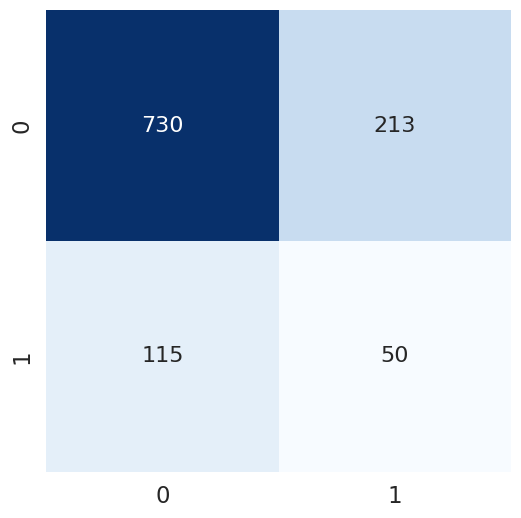

In [ ]:
# https://www.analyticsvidhya.com/blog/2020/10/improve-class-imbalance-class-weights/

print('The accuracy for model is:', accuracy_score(y_test, pred_test))
print('The f1 score for the model is:', f1_score(y_test, pred_test))
print('The roc score for the model is:', roc_auc_score(y_test, dt.predict_proba(X_test)[:,1]))

def conf_matrix(y_test, pred_test):    
    
    # Creating a confusion matrix
    con_mat = confusion_matrix(y_test, pred_test)
    con_mat = pd.DataFrame(con_mat, range(2), range(2))
   
    #Ploting the confusion matrix
    plt.figure(figsize=(6,6))
    sns.set(font_scale=1.5) 
    sns.heatmap(con_mat, annot=True, annot_kws={"size": 16}, fmt='g', cmap='Blues', cbar=False)
    
# Calling function 
conf_matrix(y_test, pred_test)

# Decision Tree Classifier of multiple predictors -> wood frame

In [ ]:
full_df = full_df.dropna()

X_ver2 = full_df[['sqft', 'num_floors', 'num_tenants', 'region', 'property_type_encoded']]
y_ver2 = full_df['has_wood_frame']

X_ver2

,sqft,num_floors,num_tenants,region,property_type_encoded
16,2586,1.0,1.0,3,3
17,10640,1.0,1.0,2,3
18,10640,1.0,1.0,2,3
50,10532,1.0,1.0,3,3
142,4265,1.0,1.0,2,3
...,...,...,...,...,...
5514,27843,4.0,8.0,1,1
5518,133778,2.0,1.0,3,0
5519,43200,2535.0,2.0,2,0
5521,20537,1.0,5.0,4,0


Checking assumption of importance of features:

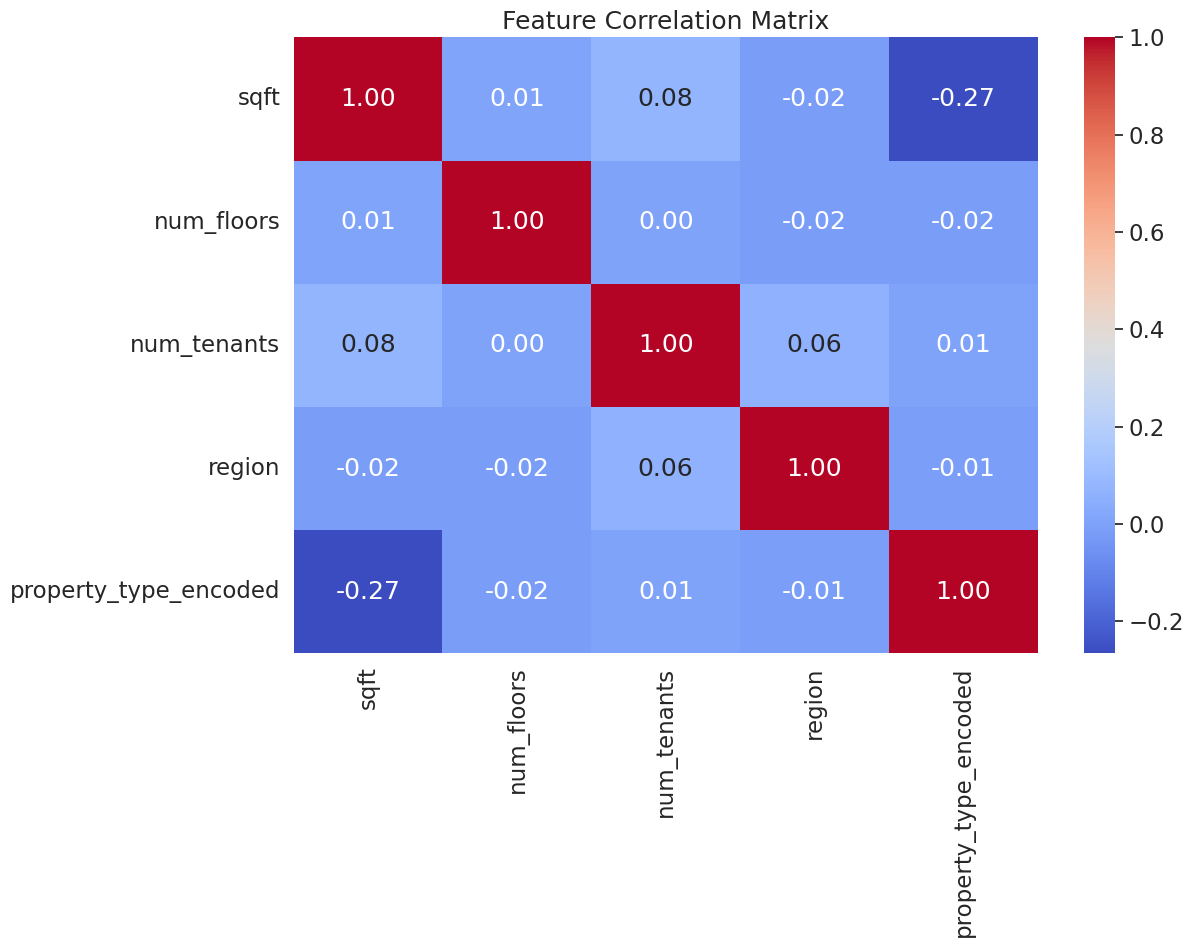

In [ ]:
correlation_matrix = X_ver2.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Matrix')
plt.show()

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_ver2, y_ver2, test_size=0.2, random_state=42)

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
dt1 = DecisionTreeClassifier(class_weight=dict(enumerate(class_weights)))  # to manage extreme class imbalance

dt1.fit(X_train, y_train)

# Predicting on the test data
pred_test = dt1.predict(X_test)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, pred_test))

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.87      0.83        82
           1       0.15      0.10      0.12        20

    accuracy                           0.72       102
   macro avg       0.48      0.48      0.48       102
weighted avg       0.67      0.72      0.69       102



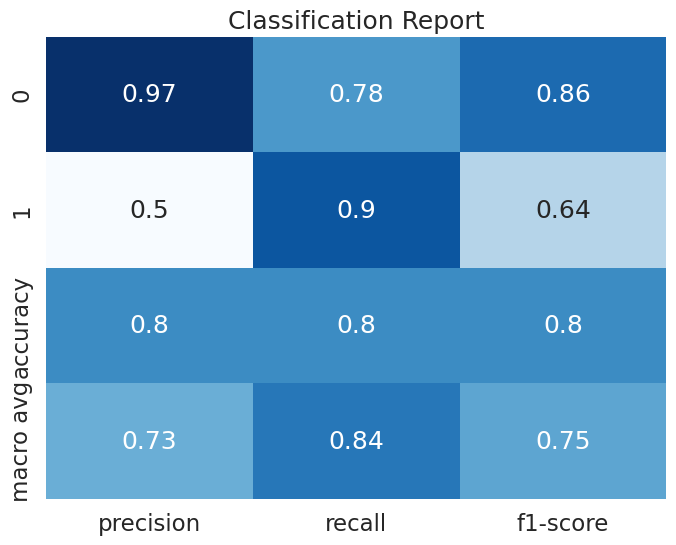

In [ ]:

# Get classification report as DataFrame
report = classification_report(y_test, pred_test, output_dict=True)
df_report = pd.DataFrame(report).transpose()

# Plotting classification report heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df_report.iloc[:-1, :-1], annot=True, cmap='Blues', cbar=False)
plt.title('Classification Report')
plt.show()


/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)


<Figure size 1200x1000 with 0 Axes>

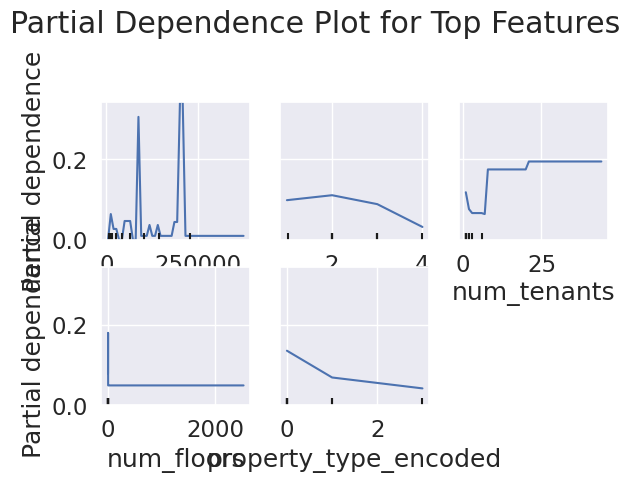

In [ ]:
from sklearn.inspection import plot_partial_dependence

# Plot partial dependence for top features
features_to_plot = sorted_idx[:5]  # Choose top 5 important features
plt.figure(figsize=(12, 10))
plot_partial_dependence(dt1, X_train, features_to_plot, feature_names=X_train.columns, grid_resolution=50)
plt.suptitle('Partial Dependence Plot for Top Features', y=1.02)
plt.tight_layout()
plt.show()


## Metrics

The accuracy for model is: 0.7156862745098039
The f1 score for the model is: 0.12121212121212123
The roc score for the model is: 0.4829268292682927


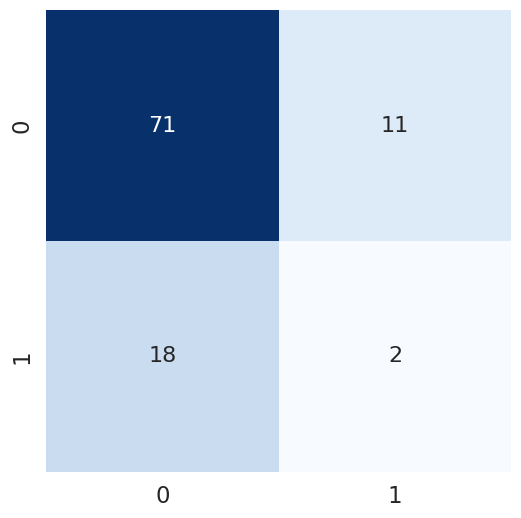

In [ ]:
# https://www.analyticsvidhya.com/blog/2020/10/improve-class-imbalance-class-weights/

print('The accuracy for model is:', accuracy_score(y_test, pred_test))
print('The f1 score for the model is:', f1_score(y_test, pred_test))
print('The roc score for the model is:', roc_auc_score(y_test, dt1.predict_proba(X_test)[:,1]))

def conf_matrix(y_test, pred_test):    
    
    # Creating a confusion matrix
    con_mat = confusion_matrix(y_test, pred_test)
    con_mat = pd.DataFrame(con_mat, range(2), range(2))
   
    #Ploting the confusion matrix
    plt.figure(figsize=(6,6))
    sns.set(font_scale=1.5) 
    sns.heatmap(con_mat, annot=True, annot_kws={"size": 16}, fmt='g', cmap='Blues', cbar=False)
    
# Calling function 
conf_matrix(y_test, pred_test)

Trying out different methods to account for extreme class imbalance:

In [ ]:
# SAME as above but using SMOTE technique

X_train, X_test, y_train, y_test = train_test_split(X_ver2, y_ver2, test_size=0.2, random_state=42)

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
dt2 = DecisionTreeClassifier(class_weight=dict(enumerate(class_weights)), random_state=42)

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

dt2.fit(X_train_smote, y_train_smote)

# Predicting on the test data
pred_test = dt2.predict(X_test)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, pred_test))

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.89      0.87        82
           1       0.47      0.40      0.43        20

    accuracy                           0.79       102
   macro avg       0.66      0.65      0.65       102
weighted avg       0.78      0.79      0.79       102



The accuracy for model is: 0.7941176470588235
The f1 score for the model is: 0.4324324324324324
The roc score for the model is: 0.6451219512195122


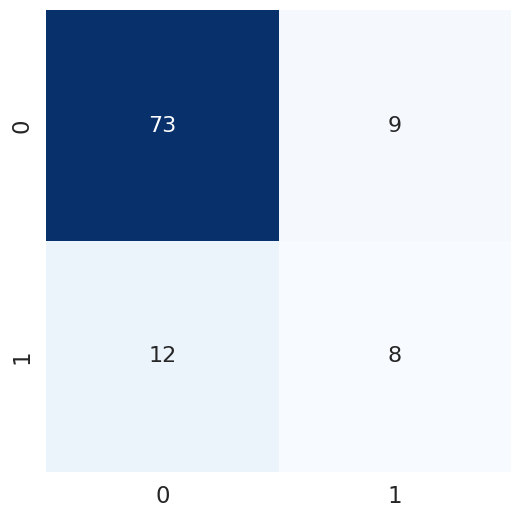

In [ ]:
# https://www.analyticsvidhya.com/blog/2020/10/improve-class-imbalance-class-weights/

print('The accuracy for model is:', accuracy_score(y_test, pred_test))
print('The f1 score for the model is:', f1_score(y_test, pred_test))
print('The roc score for the model is:', roc_auc_score(y_test, dt2.predict_proba(X_test)[:,1]))

def conf_matrix(y_test, pred_test):    
    
    # Creating a confusion matrix
    con_mat = confusion_matrix(y_test, pred_test)
    con_mat = pd.DataFrame(con_mat, range(2), range(2))
   
    #Ploting the confusion matrix
    plt.figure(figsize=(6,6))
    sns.set(font_scale=1.5) 
    sns.heatmap(con_mat, annot=True, annot_kws={"size": 16}, fmt='g', cmap='Blues', cbar=False)
    
# Calling function 
conf_matrix(y_test, pred_test)

In [ ]:
# SAME as above but using balanced random forest classifier

X_train, X_test, y_train, y_test = train_test_split(X_ver2, y_ver2, test_size=0.2, random_state=42)

dt3 = BalancedRandomForestClassifier(random_state=42)
dt3.fit(X_train, y_train)

# Predicting on the test data
pred_test = dt3.predict(X_test)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, pred_test))

/root/venv/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/root/venv/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/root/venv/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.
  warn(
Classification Report:
   

The accuracy for model is: 0.7058823529411765
The f1 score for the model is: 0.5454545454545454
The roc score for the model is: 0.7862804878048781


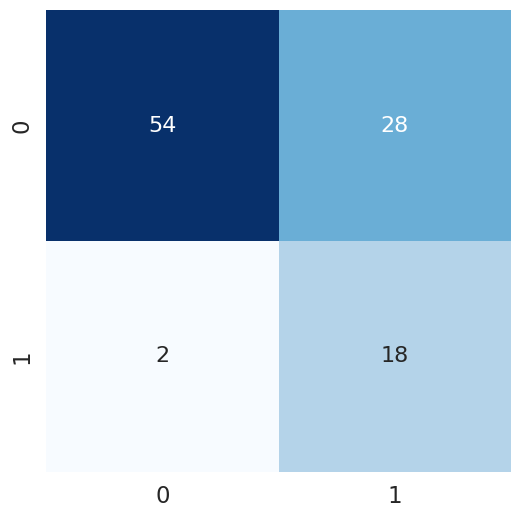

In [ ]:
# https://www.analyticsvidhya.com/blog/2020/10/improve-class-imbalance-class-weights/

print('The accuracy for model is:', accuracy_score(y_test, pred_test))
print('The f1 score for the model is:', f1_score(y_test, pred_test))
print('The roc score for the model is:', roc_auc_score(y_test, dt3.predict_proba(X_test)[:,1]))

def conf_matrix(y_test, pred_test):    
    
    # Creating a confusion matrix
    con_mat = confusion_matrix(y_test, pred_test)
    con_mat = pd.DataFrame(con_mat, range(2), range(2))
   
    #Ploting the confusion matrix
    plt.figure(figsize=(6,6))
    sns.set(font_scale=1.5) 
    sns.heatmap(con_mat, annot=True, annot_kws={"size": 16}, fmt='g', cmap='Blues', cbar=False)
    
# Calling function 
conf_matrix(y_test, pred_test)

/root/venv/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/root/venv/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/root/venv/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.
  warn(
Classification Report:
   

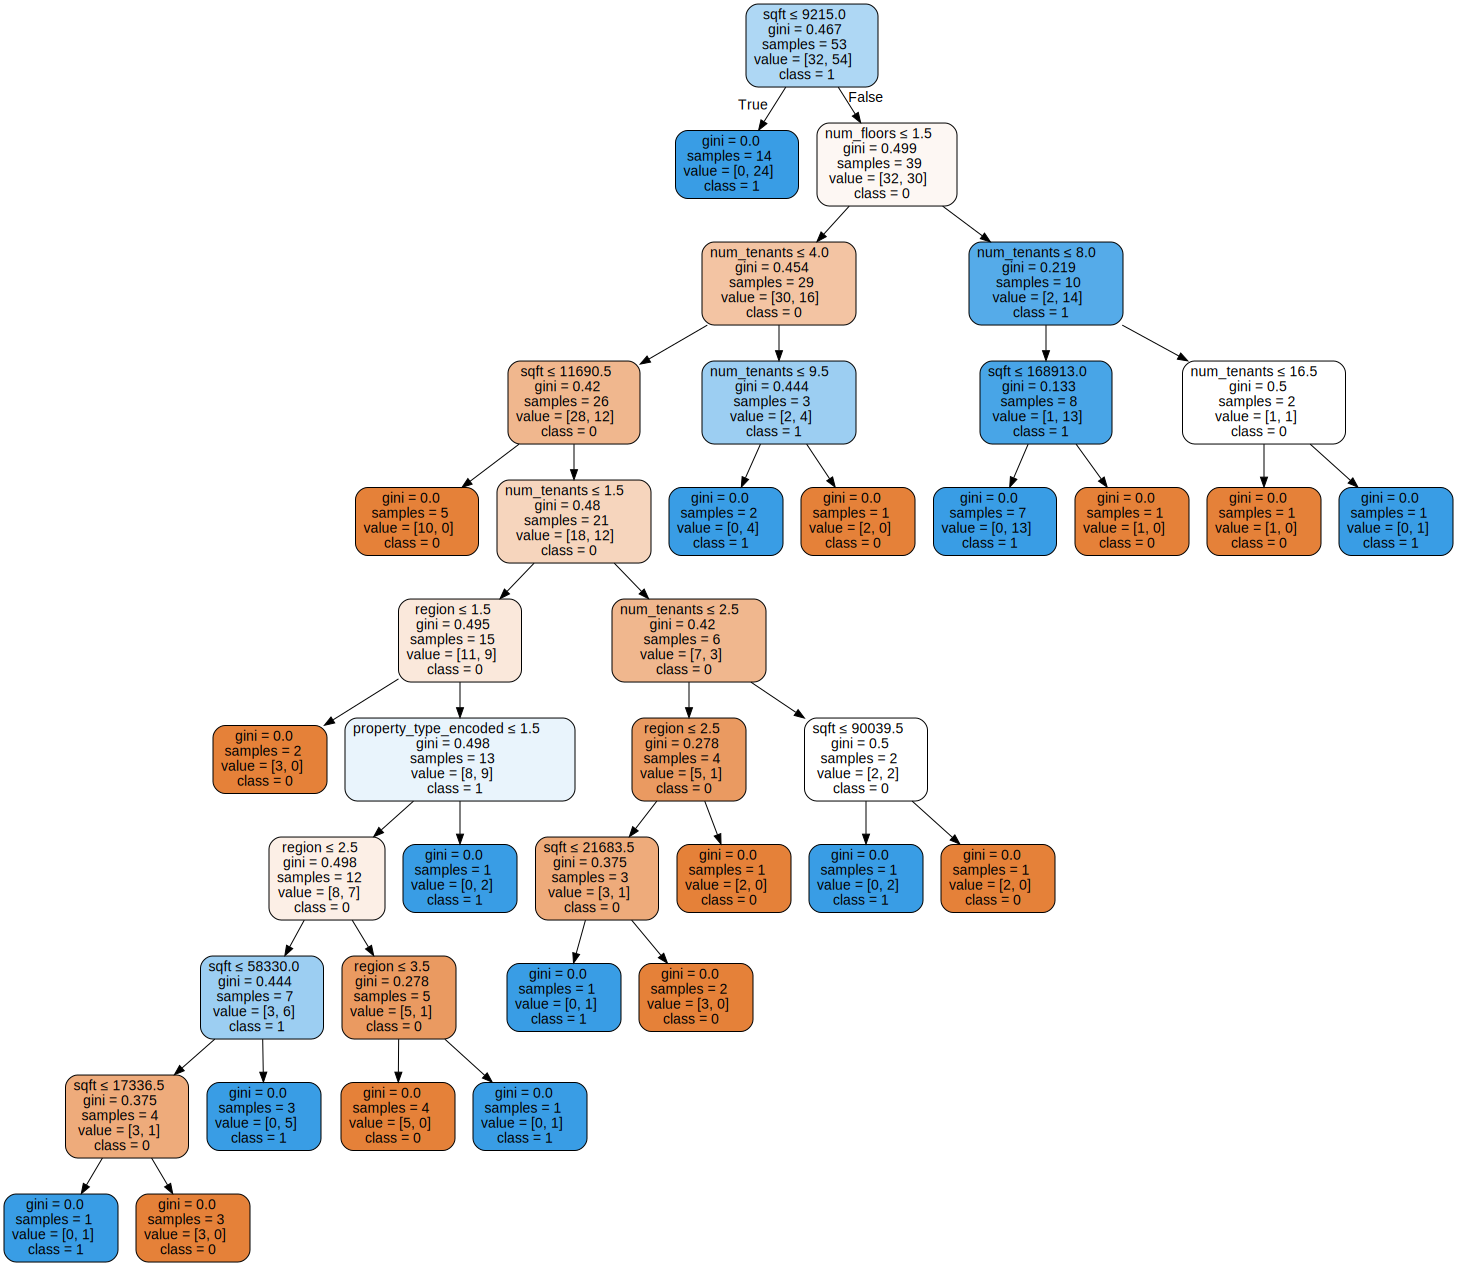

In [ ]:
from sklearn.tree import export_graphviz
import graphviz
# SAME as above but using SMOTE & balanced random forest classifier

X_train, X_test, y_train, y_test = train_test_split(X_ver2, y_ver2, test_size=0.2, random_state=42)

dt4 = BalancedRandomForestClassifier(random_state=42)

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

dt4.fit(X_train_smote, y_train_smote)

# Predicting on the test data
pred_test = dt4.predict(X_test)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, pred_test))

# Plotting the flowchart
dot_data = export_graphviz(dt3.estimators_[0], out_file=None, feature_names=X_train.columns, class_names=list(map(str, dt3.classes_)),
                           filled=True, rounded=True, special_characters=True)

graph = graphviz.Source(dot_data)
graph.render("balanced_random_forest_flowchart", format='png', cleanup=True)  # Save as PNG
graph


The accuracy for model is: 0.7843137254901961
The f1 score for the model is: 0.3125
The roc score for the model is: 0.7978658536585366


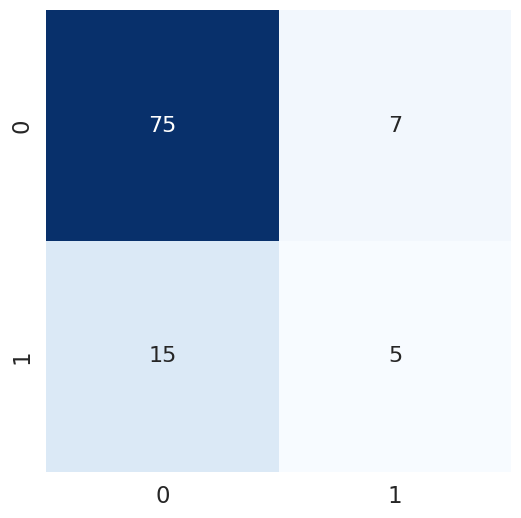

In [ ]:
# https://www.analyticsvidhya.com/blog/2020/10/improve-class-imbalance-class-weights/

print('The accuracy for model is:', accuracy_score(y_test, pred_test))
print('The f1 score for the model is:', f1_score(y_test, pred_test))
print('The roc score for the model is:', roc_auc_score(y_test, dt4.predict_proba(X_test)[:,1]))

def conf_matrix(y_test, pred_test):    
    
    # Creating a confusion matrix
    con_mat = confusion_matrix(y_test, pred_test)
    con_mat = pd.DataFrame(con_mat, range(2), range(2))
   
    #Ploting the confusion matrix
    plt.figure(figsize=(6,6))
    sns.set(font_scale=1.5) 
    sns.heatmap(con_mat, annot=True, annot_kws={"size": 16}, fmt='g', cmap='Blues', cbar=False)
    
# Calling function 
conf_matrix(y_test, pred_test)

## Feature Importance

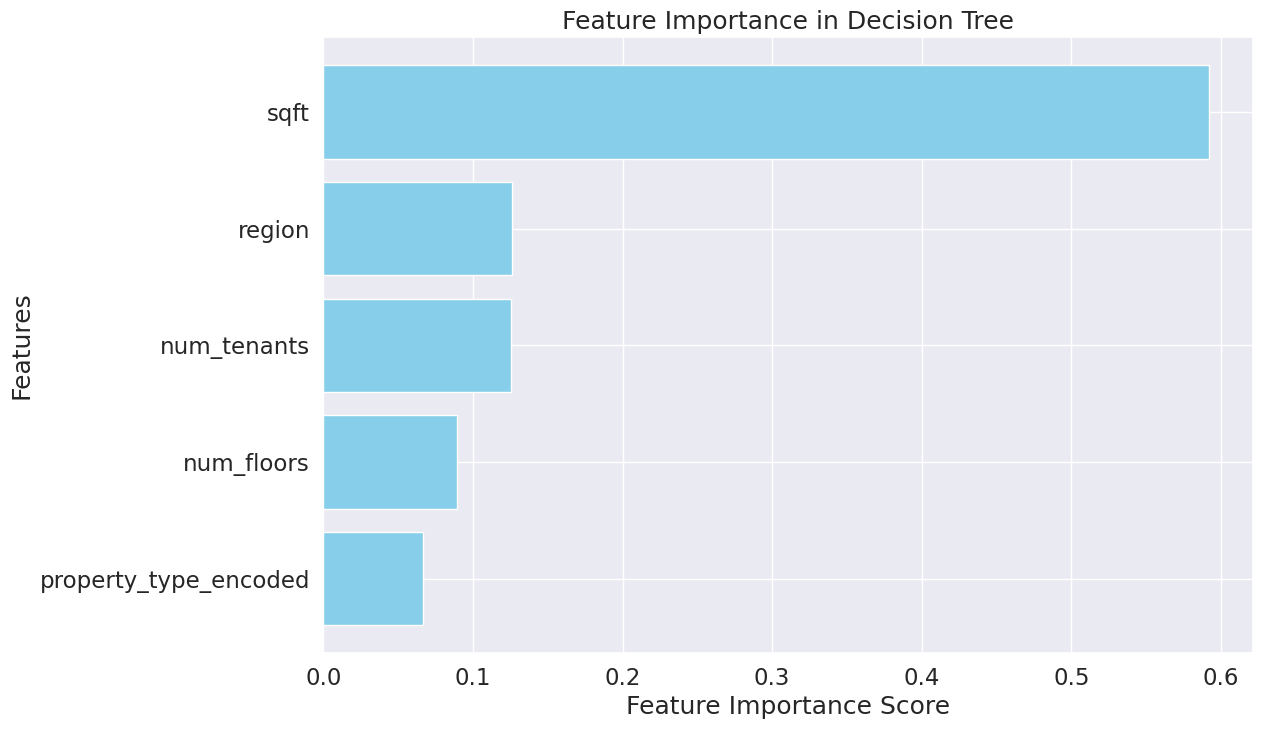

In [ ]:
feature_importances = dt3.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': X_ver2.columns,
    'Importance': feature_importances
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance in Decision Tree')
plt.gca().invert_yaxis()
plt.show()

# "Post Expo" Models

Following our Expo presentation, there have been several alternative techniques that we have considered to try and improve the "Successful Model" even further:

### Different Weight Values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_ver2, y_ver2, test_size=0.2, random_state=42)

# including balanced weight to class weight
dt5 = BalancedRandomForestClassifier(class_weight='balanced', random_state=42)
dt5.fit(X_train, y_train)

# Predicting on the test data
pred_test = dt5.predict(X_test)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, pred_test))

/root/venv/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/root/venv/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/root/venv/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.
  warn(
Classification Report:
   

Including a 'balanced' weight does not appear to dramatically improve the model at all.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_ver2, y_ver2, test_size=0.2, random_state=42)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: class_weights[i] for i in np.unique(y_train)}

# including balanced weight to class weight
dt5 = BalancedRandomForestClassifier(class_weight=class_weight_dict, random_state=42)
dt5.fit(X_train, y_train)

# Predicting on the test data
pred_test = dt5.predict(X_test)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, pred_test))

/root/venv/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/root/venv/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/root/venv/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.
  warn(
Classification Report:
   

The accuracy for model is: 0.7156862745098039
The f1 score for the model is: 0.5538461538461539
The roc score for the model is: 0.7746951219512195


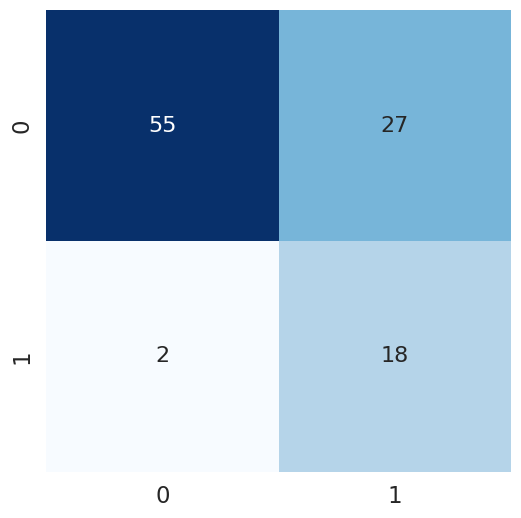

In [ ]:
# https://www.analyticsvidhya.com/blog/2020/10/improve-class-imbalance-class-weights/

print('The accuracy for model is:', accuracy_score(y_test, pred_test))
print('The f1 score for the model is:', f1_score(y_test, pred_test))
print('The roc score for the model is:', roc_auc_score(y_test, dt5.predict_proba(X_test)[:,1]))

def conf_matrix(y_test, pred_test):    
    
    # Creating a confusion matrix
    con_mat = confusion_matrix(y_test, pred_test)
    con_mat = pd.DataFrame(con_mat, range(2), range(2))
   
    #Ploting the confusion matrix
    plt.figure(figsize=(6,6))
    sns.set(font_scale=1.5) 
    sns.heatmap(con_mat, annot=True, annot_kws={"size": 16}, fmt='g', cmap='Blues', cbar=False)
    
# Calling function 
conf_matrix(y_test, pred_test)

This method of computing weights for each class in such a way that they are inversely proportional to the class frequencies in the input data was also not effective.

(How is works: balances the dataset by assigning higher weights to less frequent classes and lower weights to more frequent classes. This ensures that the classifier pays more attention to the minority classes during training.)

### Different Hyperparameters

In [ ]:
# Same as Successful Model call but with tweaked training parameters

X_train, X_test, y_train, y_test = train_test_split(X_ver2, y_ver2, test_size=0.2, random_state=42)

# Here, dt5 makes tweaks to the estimator, depth, criterion, and other hyperparameters
dt5 = BalancedRandomForestClassifier(n_estimators=200, max_depth=10, min_samples_split=10, min_samples_leaf=5, max_features='sqrt', criterion='entropy', random_state=42)
dt5.fit(X_train, y_train)

# Predicting on the test data
pred_test = dt5.predict(X_test)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, pred_test))

/root/venv/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/root/venv/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/root/venv/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.
  warn(
Classification Report:
   

The accuracy for model is: 0.803921568627451
The f1 score for the model is: 0.6428571428571429
The roc score for the model is: 0.8246951219512195


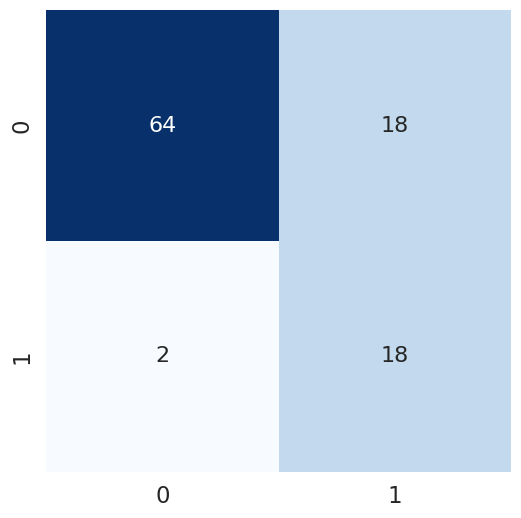

In [ ]:
# https://www.analyticsvidhya.com/blog/2020/10/improve-class-imbalance-class-weights/

print('The accuracy for model is:', accuracy_score(y_test, pred_test))
print('The f1 score for the model is:', f1_score(y_test, pred_test))
print('The roc score for the model is:', roc_auc_score(y_test, dt5.predict_proba(X_test)[:,1]))

def conf_matrix(y_test, pred_test):    
    
    # Creating a confusion matrix
    con_mat = confusion_matrix(y_test, pred_test)
    con_mat = pd.DataFrame(con_mat, range(2), range(2))
   
    #Ploting the confusion matrix
    plt.figure(figsize=(6,6))
    sns.set(font_scale=1.5) 
    sns.heatmap(con_mat, annot=True, annot_kws={"size": 16}, fmt='g', cmap='Blues', cbar=False)
    
# Calling function 
conf_matrix(y_test, pred_test)

We now have an accuracy of 80% and f1-score of 0.86, just from tweaking the hyperparameters. 

Some hyperparameter alterations that improved the model:

- Increasing the number of estimators (trees) - makes model less prone to effects of noise in individual trees

- Reducing max depth - reduces complexity / chance of overfitting

- Specifying criterion as entropy - may produce more balanced trees than gini 

In [ ]:
# Attempt using GridSearch to find best hyperparameters

X_train, X_test, y_train, y_test = train_test_split(X_ver2, y_ver2, test_size=0.2, random_state=42)

dt5 = BalancedRandomForestClassifier()

param_grid = {
    'n_estimators': [180, 200, 220],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10],
    'max_features': ['auto', 'sqrt', 'log2']
    }

# Set up the GridSearchCV
grid_search = GridSearchCV(estimator=dt5, param_grid=param_grid, cv=5, scoring='f1')  # trying out 5 folds

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Print the best parameters and the scores
print("Best parameters: ", grid_search.best_params_)
print("Best F1 score: ", grid_search.best_score_)

  warn(
/root/venv/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.
  warn(
/root/venv/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/root/venv/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/root/venv/lib/pyt

KeyboardInterrupt: 

In [ ]:
# Attempt using GridSearch to find best hyperparameters

X_train, X_test, y_train, y_test = train_test_split(X_ver2, y_ver2, test_size=0.2, random_state=42)

dt5 = BalancedRandomForestClassifier()

param_grid = {
    'n_estimators': [180, 200, 220],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Set up the GridSearchCV
grid_search = GridSearchCV(estimator=dt5, param_grid=param_grid, cv=5, scoring='accuracy')  # trying out 5 folds

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Print the best parameters and the scores
print("Best parameters: ", grid_search.best_params_)
print("Best Accuracy score: ", grid_search.best_score_)

/root/venv/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/root/venv/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.
  warn(
/root/venv/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/root/venv/lib/python3.9/s

Why?

Hyperparameters refer to configurations in a machine learning model that manage how it learns. Instances could be the quantity of trees in a haphazard forest or the pace of learning in a support vector machine. Hyperparameters are determined before training, while model parameters are learned from data.
Grid Search: GridSearchCV methodically explores various combinations of hyperparameter values within a predetermined grid. This grid establishes the potential values for each hyperparameter.
Cross-Validation is used by GridSearchCV to assess the performance of each combination of hyperparameters. The data is divided into folds, the model is trained on certain folds using a particular hyperparameter configuration, and tested on the rest of the folds. All folds and hyperparameter combinations undergo this process again.

As such we found that: our model does well in that particular group of data that is present in the test data, but it does not generalize well. For a model to generalize well, your cross-validation results AND your test results should be high. In other words, our model has overfitted to set of data.

### Synthetic Sampling - SMOTE (Synthetic Minority Over-sampling Technique)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_ver2, y_ver2, test_size=0.2, random_state=42)

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
dt6 = DecisionTreeClassifier(class_weight=dict(enumerate(class_weights)), random_state=42)

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

dt6.fit(X_train_smote, y_train_smote)

# Predicting on the test data
pred_test = dt6.predict(X_test)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, pred_test))

How? Addresses class imbalance in datasets by generating new synthetic samples for the minority class.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=aa72ad5b-4609-409b-ae7e-8a5fd2e73142' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>